In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [2]:
import tensorflow as tf
from tensorflow import keras

%load_ext tensorboard

2023-12-28 02:09:26.395336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 02:09:26.587971: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 02:09:27.327961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-28 02:09:27.328066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
# we'll read both of these values and the original input and irrelevant tcrs
cdr3_to_X = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
ag_to_X = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [4]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [8]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# complete 10 iterations
for seed in range(10):
    ## SETUP CONSTANTS
    # grab a subset
    np.random.seed(seed)
    n_rows = hit.shape[0] // 2
    perc_train = 0.75

    
    ## SEPARATE OUT TRAINING AND TESTING
    # train and test
    # > subset target
    idxs = np.random.choice(hit.index, size=n_rows, replace=False)
    idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
    print(len(idxs), len(idys))
    hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
    # > subset control
    idxs = np.random.choice(irr.index, size=n_rows, replace=False)
    idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
    print(len(idxs), len(idys))
    irr_train, irr_test = irr.loc[idxs], irr.loc[idys]
    # confirm no overlap
    assert not hit_train.index.isin(hit_test.index).all()
    assert not irr_train.index.isin(irr_test.index).all()
    
    # validation
    # > subset target
    val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
    print(len(val_idxs))
    hit_val = hit.loc[val_idxs]
    # > subset control
    val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
    print(len(val_idxs))
    irr_val = irr.loc[val_idxs]

    
    ## CONVERT TO CORRECT FORMAT
    # create X for training
    X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
    cdr3s_training = X_train['CDR3'].unique()
    X_train_cdr3s = cdr3_to_X.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = ag_to_X.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # grab y for training
    y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])),
                         pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
    y_train = y_train.reset_index().iloc[:, 1:][0]

    # confirm the same length
    assert X_train.shape[0] == y_train.shape[0]

    # create X for testing
    X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
    X_test_cdr3s = cdr3_to_X.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
    X_test_epitopes = ag_to_X.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
    X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
    X_test = X_test_cdr3s.join(X_test_epitopes)

    # grab y for testing
    y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])),
                         pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
    y_test = y_test.reset_index().iloc[:, 1:][0]

    # confirm the same length
    assert X_test.shape[0] == y_test.shape[0]

    # create X for validation
    X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
    # strip validation of any overlapping CDR3s from training
    mask = X_val['CDR3'].isin(cdr3s_training)
    print(X_val.shape[0], sum(~mask))
    X_val = X_val.loc[~mask]
    X_val_cdr3s = cdr3_to_X.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = ag_to_X.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)

    # grab y for validation
    y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])),
                         pd.Series(np.zeros(irr_val.shape[0]))], axis=0).astype(int)
    y_val = y_val.reset_index().iloc[:, 1:][0].loc[~mask]

    # confirm the same length
    assert X_val.shape[0] == y_val.shape[0]

    # remove constant columns
    X_train = X_train.loc[:, X_train.nunique(0) > 1]
    X_train = X_train.loc[:, X_train.sum(0) > 0]
    # read in normalization factors
    means = X_train.mean(0)
    stds = (X_train - means).std(0)
    # subset for relevant columns
    X_train = X_train[means.index]
    X_test = X_test[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_test -= means
    X_test /= stds
    X_val -= means
    X_val /= stds

    ## SETUP MODEL
    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_test[cols_cdr3], X_test[cols_ag]], y_test),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))

47630 15877
47630 15877
63507
63507
127014 46201


2023-12-27 21:50:49.923220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-12-27 21:50:49.923251: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-12-27 21:50:49.923549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2977/2977 [==============================] - 17s 5ms/step - loss: 0.6085 - accuracy: 0.6239 - auc: 0.6949 - val_loss: 0.5733 - val_accuracy: 0.6646 - val_auc: 0.7445
Epoch 2/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5520 - accuracy: 0.6858 - auc: 0.7703 - val_loss: 0.5377 - val_accuracy: 0.6970 - val_auc: 0.7861
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5014 - accuracy: 0.7308 - auc: 0.8221 - val_loss: 0.5079 - val_accuracy: 0.7260 - val_auc: 0.8189
Epoch 4/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4420 - accuracy: 0.7772 - auc: 0.8695 - val_loss: 0.4827 - val_accuracy: 0.7533 - val_auc: 0.8464
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3817 - accuracy: 0.8161 - auc: 0.9065 - val_loss: 0.4726 - val_accuracy: 0.7696 - val_auc: 0.8607
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3292 - accuracy: 0.8471 - auc: 0.932

Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3795 - accuracy: 0.8169 - auc: 0.9076 - val_loss: 0.4658 - val_accuracy: 0.7699 - val_auc: 0.8612
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3253 - accuracy: 0.8492 - auc: 0.9338 - val_loss: 0.4677 - val_accuracy: 0.7811 - val_auc: 0.8726
Epoch 7/10
2977/2977 [==============================] - 13s 5ms/step - loss: 0.2812 - accuracy: 0.8718 - auc: 0.9513 - val_loss: 0.4734 - val_accuracy: 0.7892 - val_auc: 0.8783
Epoch 8/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.2444 - accuracy: 0.8909 - auc: 0.9636 - val_loss: 0.4858 - val_accuracy: 0.7938 - val_auc: 0.8823
Epoch 9/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.2145 - accuracy: 0.9060 - auc: 0.9721 - val_loss: 0.4873 - val_accuracy: 0.8033 - val_auc: 0.8882
Epoch 10/10
1452/1452 [==============================] - 3s 2ms/step
47630 15877
47630 15877
63507
63507
127014 462

Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2195 - accuracy: 0.9047 - auc: 0.9708 - val_loss: 0.4923 - val_accuracy: 0.7996 - val_auc: 0.8858
Epoch 10/10
1452/1452 [==============================] - 3s 2ms/step
47630 15877
47630 15877
63507
63507
127014 46417
Epoch 1/10
2977/2977 [==============================] - 15s 5ms/step - loss: 0.6071 - accuracy: 0.6260 - auc: 0.6976 - val_loss: 0.5752 - val_accuracy: 0.6582 - val_auc: 0.7400
Epoch 2/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5515 - accuracy: 0.6855 - auc: 0.7706 - val_loss: 0.5392 - val_accuracy: 0.6947 - val_auc: 0.7853
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5034 - accuracy: 0.7289 - auc: 0.8210 - val_loss: 0.5185 - val_accuracy: 0.7179 - val_auc: 0.8135
Epoch 4/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4460 - accuracy: 0.7758 - auc: 0.8676 - val_loss: 0.4820 - val_accuracy: 0.7520 - val_auc: 0.84

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

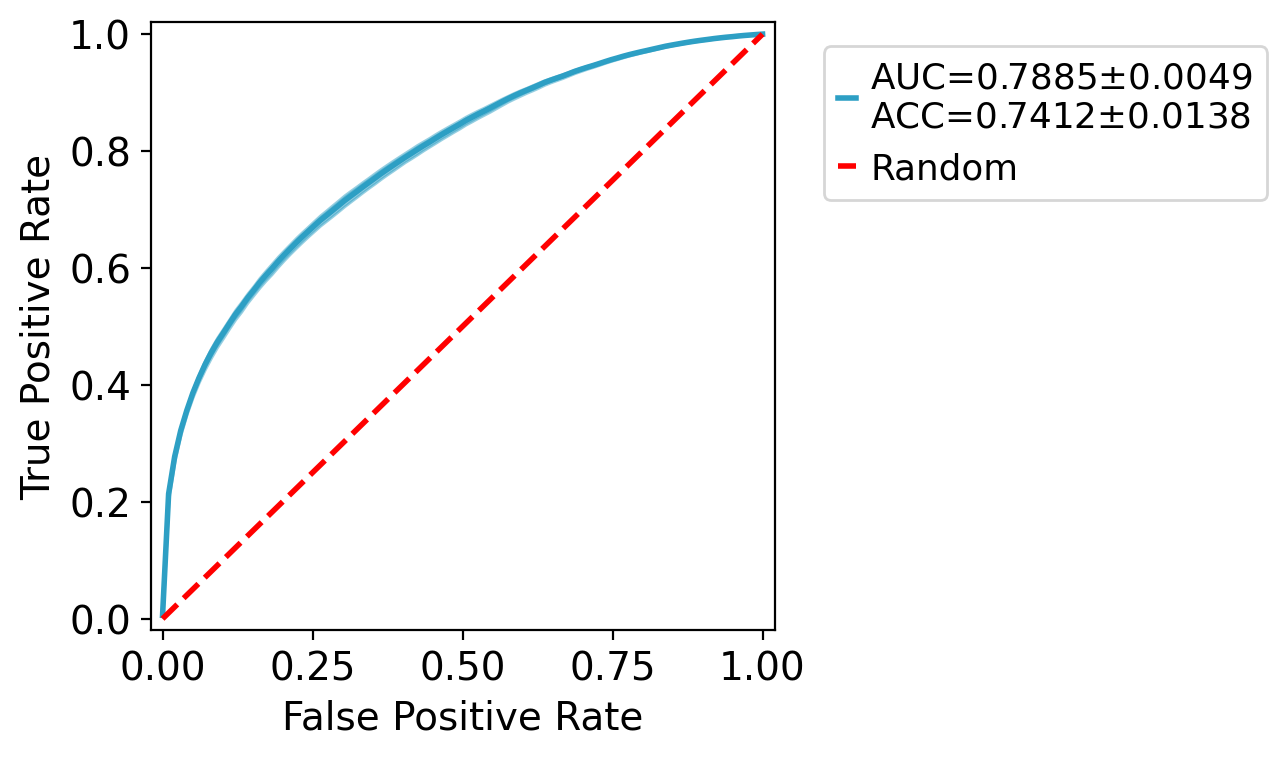

In [9]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')